<a href="https://colab.research.google.com/github/TristanConant/sales-predictions/blob/final/ml_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [77]:
file_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQcO5VAKyttMX8k6NqLE5Q5wHBt1ZVvuQ-Emy8aAvUOlbLrt_dcvqbBnGLtI3fDP_gAgdlmlfed1c3i/pub?gid=883441261&single=true&output=csv'
df = pd.read_csv(file_url)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [78]:
# DF copy to preserve integrity of original dataframe
ml_df = df.copy()
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [79]:
# Empty list to store gathered metrics for comparison
metrics = []

# DataFrame Management and Cleanup



In [80]:
# Checking for duplicates
ml_df.duplicated().sum()

0

In [81]:
# Checking for missing data.
# Missing values will be handled during column transformation
ml_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [82]:
# Loop over object columns and return a count of  unique values
dtypes = ml_df.dtypes
str_cols = dtypes[dtypes=='object'].index

for col in str_cols:
  print(f'Column: {col}')
  print(ml_df[col].value_counts())
  print('\n\n')

Column: Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64



Column: Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



Column: Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



Column: Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT01

In [83]:
# Fixing object column inconsistencies
ml_df['Item_Fat_Content'].replace('low fat', 'Low Fat', inplace=True)
ml_df['Item_Fat_Content'].replace('LF', 'Low Fat', inplace=True)
ml_df['Item_Fat_Content'].replace('reg', 'Regular', inplace=True)

# Checking that the changes were applied as expected
for col in str_cols:
  print(f'Column: {col}')
  print(ml_df[col].value_counts())
  print('\n\n')

Column: Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64



Column: Item_Fat_Content
Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64



Column: Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



Column: Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    5

# Preprocessing

#### Train test split

In [84]:
# Defining the feature set by dropping the target column and irrelevant columns. 
X = ml_df.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Establishment_Year'])
# Defining the target set.
y = ml_df['Item_Outlet_Sales']

In [85]:
# Performing the train test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Preprocessing pipelines


In [86]:
# Instantiating standard scaler
scaler = StandardScaler()

# Instantiating OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')

# Instantiating simple imputers
mean_imputer = SimpleImputer(strategy='mean')
most_frequent_imputer = SimpleImputer(strategy='most_frequent')

# Defining list of values for ordinal encoder
size_labels = ['High', 'Medium', 'Small']
type_labels = ['Tier 1','Tier 2','Tier 3']
ordered_labels = [size_labels, type_labels]

# Instantiating ordinal encoder
ordinal = OrdinalEncoder(categories=ordered_labels)

In [87]:
# Numeric pipline
num_pipe = make_pipeline(mean_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [88]:
# Ordinal pipeline
ord_pipe = make_pipeline(most_frequent_imputer, ordinal, scaler)
ord_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['High', 'Medium', 'Small'],
                                            ['Tier 1', 'Tier 2', 'Tier 3']])),
                ('standardscaler', StandardScaler())])

In [89]:
# Nominal pipline
nom_pipe = make_pipeline(most_frequent_imputer, ohe)
nom_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

### Column transformation

In [90]:
# Creating column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type']
ord_selector = ['Outlet_Size', 'Outlet_Location_Type']

# Matching transformers with columns
num_tuple = (num_pipe, num_selector)
nom_tuple = (nom_pipe, cat_selector)
ord_tuple = (ord_pipe, ord_selector)

In [91]:
# Instantiate the ColumnTransformer
col_transformer = make_column_transformer(num_tuple, nom_tuple, ord_tuple, remainder='passthrough')

In [92]:
# Fit transformer to the train data
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc48c1c3510>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHo...ore'))]),
                                 ['Item_Fat_Content', 'Item_Type',
                                  'Outlet_Identifier', 'Outlet_Type']),
                                ('pip

In [93]:
# Transform the training and test data sets
X_train = col_transformer.transform(X_train)
X_test = col_transformer.transform(X_test)

# Linear Regression Model

In [94]:
# Instantiating linear regression model
reg = LinearRegression()

In [95]:
# Fitting the model to the train data
reg.fit(X_train, y_train)

LinearRegression()

### Regression model metrics

In [96]:
# Storing model predictions on the test data
reg_train_pred = reg.predict(X_train)
reg_test_pred = reg.predict(X_test)

# R2
reg_train_r2 = r2_score(y_train, reg_train_pred)
reg_test_r2 = r2_score(y_test, reg_test_pred)
reg_diff_r2 = reg_train_r2 - reg_test_r2

# RMSE
reg_train_RMSE = np.sqrt(mean_squared_error(y_train, reg_train_pred))
reg_test_RMSE = np.sqrt(mean_squared_error(y_test, reg_test_pred))
reg_diff_RMSE = reg_train_RMSE - reg_test_RMSE

metrics.append([
  'Linear Regression',
  reg_train_r2,
  reg_test_r2,
  reg_diff_r2,
  reg_train_RMSE,
  reg_train_RMSE,
  reg_train_RMSE 
])

# Regression Tree Model

In [98]:
# Instantiating the regression tree model
dec_tree = DecisionTreeRegressor(random_state = 42)
# fitting the model to the train data
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

### Model tuning

In [100]:
# Finding the models max possible depth
dec_tree.get_depth()

44

Now that the max possible depth is known, that value can be used to set a range of depths. The following loop will store the R2 score for each depth.

In [101]:
depths = list(range(2, 44))
dec_tree_scores = pd.DataFrame(index = depths, columns = ['Test Score', 'Train Score'])
for depth in depths:
  dec_tree = DecisionTreeRegressor(max_depth = depth, random_state = 42)
  dec_tree.fit(X_train, y_train)
  dec_tree_train_score = dec_tree.score(X_train, y_train)
  dec_tree_test_score = dec_tree.score(X_test, y_test)
  dec_tree_scores.loc[depth, 'Train Score'] = dec_tree_train_score
  dec_tree_scores.loc[depth, 'Test Score'] = dec_tree_test_score

With R2 scores stored the plot below will help visualize the optimal max depth to be used.

Text(0, 0.5, 'R2')

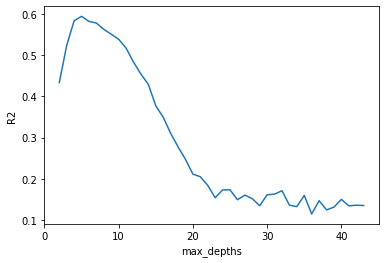

In [102]:
plt.plot(depths, dec_tree_scores['Test Score'])
plt.xlabel('max_depths')
plt.ylabel('R2')

To take and even closer look at data the scores are listed below. The index represents the max depth value.

In [104]:
# Sorting the scores
sorted_scores = dec_tree_scores.sort_values(by = 'Test Score', ascending = False)
sorted_scores.head()

,Test Score,Train Score
5,0.59471,0.60394
4,0.584005,0.582625
6,0.582274,0.615161
7,0.578448,0.626841
8,0.563016,0.643842


In [105]:
# Instantiating the decision tree model with optimal parameters
dec_tree = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [106]:
# Predictions
dec_tree_train_preds = dec_tree.predict(X_train)
dec_tree_test_preds = dec_tree.predict(X_test)

# R2
dec_tree_train_r2 = dec_tree.score(X_train, y_train)
dec_tree_test_r2 = dec_tree.score(X_test, y_test)
dec_tree_diff_r2 = dec_tree_train_r2 - dec_tree_test_r2

# RMSE
dec_tree_train_RMSE = np.sqrt(mean_squared_error(y_train, dec_tree_train_preds))
dec_tree_test_RMSE = np.sqrt(mean_squared_error(y_test, dec_tree_test_preds))
dec_tree_diff_RMSE = dec_tree_train_RMSE - dec_tree_test_RMSE

metrics.append([
  'Decision Tree',
  dec_tree_train_r2,
  dec_tree_test_r2,
  dec_tree_diff_r2,
  dec_tree_train_RMSE,
  dec_tree_test_RMSE,
  dec_tree_diff_RMSE 
])

# Metrics Results

In [109]:
regression_metrics = pd.DataFrame(metrics, columns = ['Model Type', 'R2 Train', 'R2 Test', 'R2 Diff', 'RMSE Train', 'RMSE Test', 'RMSE Diff'])
regression_metrics.head()

,Model Type,R2 Train,R2 Test,R2 Diff,RMSE Train,RMSE Test,RMSE Diff
0,Linear Regression,0.561555,0.567104,-0.005549,1139.104094,1139.104094,1139.104094
1,Decision Tree,0.603940,0.594710,0.009230,1082.646190,1057.443130,25.203060


The metrics above show that both models are underfitting. I would not reccomend either model with out tuning and retesting both.